In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

C:\Users\tomsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


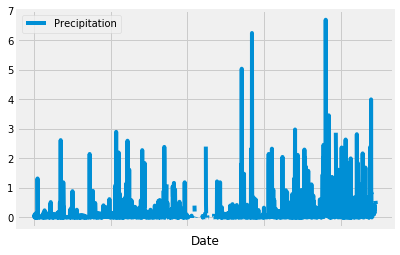

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#date_str = "14"
# data = engine.execute("SELECT * FROM Measurement WHERE date >'2016-08-22'")
# for record in data:
#     print(record)

# Calculate the date 1 year ago from the last data point in the database
   
priorYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)
priorYear

# Perform a query to retrieve the data and precipitation scores

precData = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= priorYear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prec_df = pd.DataFrame(precData, columns=['Date', 'Precipitation'])
prec_df.set_index(prec_df['Date'], inplace=True)

prec_df.head()
# Sort the dataframe by date
prec_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(x_compat=True)

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prec_df.describe(percentiles=None, include=None, exclude=None)

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?

stationCount = engine.execute("SELECT COUNT(DISTINCT station) FROM measurement")
for record in stationCount:
    print(record)


(9,)


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationActivity = engine.execute("SELECT station, COUNT(*) FROM measurement GROUP BY station ORDER BY COUNT(*) DESC")
for record in stationActivity:
    print(record)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
mostActive = engine.execute("SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station ='USC00519281'")
for record in mostActive:
    print(record)

(54.0, 85.0, 71.66378066378067)


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [17]:
# mostTemps = engine.execute("SELECT date,tobs FROM measurement WHERE station = 'USC00519281' ORDER BY date")
# for record in mostTemps:
#     print(record)
conn = engine.connect()

df_name = pd.read_sql("SELECT date,tobs FROM Measurement WHERE station == 'USC00519281' AND date >'2016-08-23'  ",conn)
df_name.head()


,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


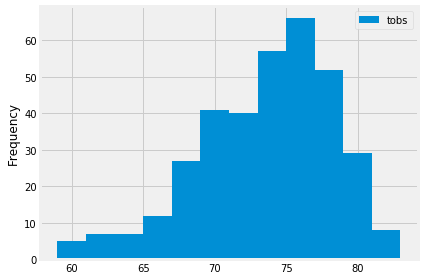

In [18]:
df_name.plot.hist(bins=12)
plt.tight_layout()


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
data= calc_temps("2016-8-23", "2017-8-23")
data

[(58.0, 74.14387974230493, 87.0)]

C:\Users\tomsh\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


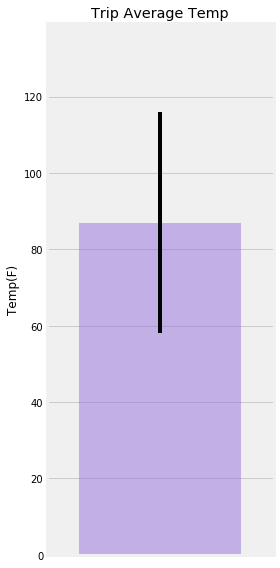

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y 
tmin, tavg, tmax=calc_temps("2016-8-23", "2017-8-23")[0]

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos=1
yerr=tmax-tmin
bar=ax.bar(xpos,tmax,yerr=yerr,alpha=0.5,color="mediumpurple",align="center")
ax.set(xticks=range(xpos),xticklabels="a",title="Trip Average Temp",ylabel="Temp(F)")
ax.margins(.2,.2)
fig.tight_layout()
fig.show()

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [24]:
stationActivity = engine.execute("SELECT station.station, name, latitude, longitude, elevation, SUM(prcp) FROM station JOIN measurement WHERE date BETWEEN '2016-8-24' AND '2017-8-23' GROUP BY station.station ORDER BY prcp DESC")
for record in stationActivity:
    print(record)

('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 210.23000000000033)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 210.23000000000033)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 210.23000000000033)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 210.23000000000033)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 210.23000000000033)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 210.23000000000033)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 210.23000000000033)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 210.23000000000033)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 210.23000000000033)


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
